In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from datetime import date

In [53]:
clim = pd.read_csv('DataRepository/jena_climate_2009_2016.csv', index_col = 0)

In [54]:
clim = clim.reset_index()
clim.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [6]:
df = clim[['Date Time','T (degC)']].rename(columns = {'T (degC)':'T','Date Time':'datetime'})
df.head()

,datetime,T
0,01.01.2009 00:10:00,-8.02
1,01.01.2009 00:20:00,-8.41
2,01.01.2009 00:30:00,-8.51
3,01.01.2009 00:40:00,-8.31
4,01.01.2009 00:50:00,-8.27


<AxesSubplot:>

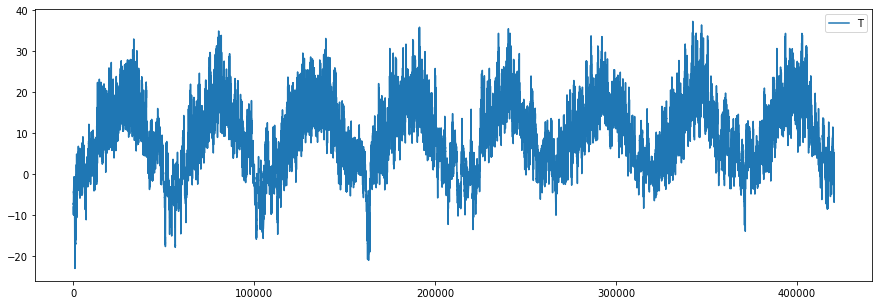

In [7]:
df.plot(figsize = (15,5))

In [8]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [9]:
type(df['datetime'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [69]:
df.head(10)

,datetime,T
0,2009-01-01 00:10:00,-8.02
1,2009-01-01 00:20:00,-8.41
2,2009-01-01 00:30:00,-8.51
3,2009-01-01 00:40:00,-8.31
4,2009-01-01 00:50:00,-8.27
5,2009-01-01 01:00:00,-8.05
6,2009-01-01 01:10:00,-7.62
7,2009-01-01 01:20:00,-7.62
8,2009-01-01 01:30:00,-7.91
9,2009-01-01 01:40:00,-8.43


In [10]:
# Taking each 6th record as we need hourly data, so we can ignore every other record (which are on 10 min level)

# We can also take mean/median of each consecutive 6 records if that is a business requirement, but right now it is not.

df_hour_lvl = df[5::6].reset_index().drop('index', axis=1)

In [77]:
df_hour_lvl.head()

,datetime,T
0,2009-01-01 01:00:00,-8.05
1,2009-01-01 02:00:00,-8.88
2,2009-01-01 03:00:00,-8.81
3,2009-01-01 04:00:00,-9.05
4,2009-01-01 05:00:00,-9.63


### Check the data distribution

<AxesSubplot:xlabel='T', ylabel='Density'>

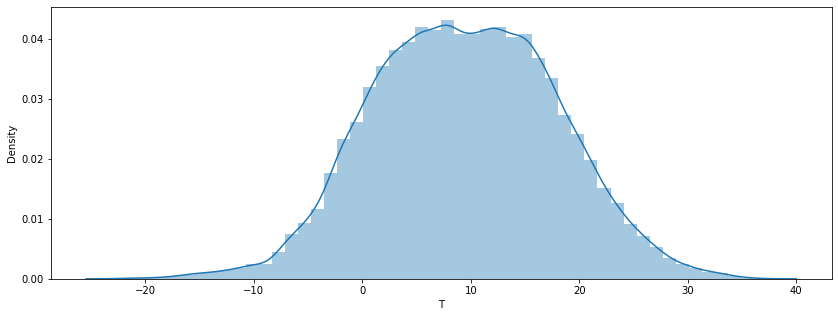

In [80]:
plt.figure(figsize = (14,5))
sns.distplot(df_hour_lvl['T'])

#### The data is a very good normally distributed data. If our data was not normally distributed, then we had to convert it into normal data using outlier removal or data transformation (usually Box-Cox Transformation) or both. In my experience, LSTMs provide very bad forecast on skewed data. As of now, this data is fine and we can proceed with this data

### Train - Test Split

In [11]:
# we cannot simply provide a sequence of data points to an LSTM model for training and testing, 
# the input X sequence must be a 2D array [no of records, n_input], while the input y sequence must be a 1D array

def Sequential_Input_LSTM(df, input_sequence):
    df_np = df.to_numpy()
    X = []
    y = []
    
    for i in range(len(df_np) - input_sequence):
        row = [a for a in df_np[i:i + input_sequence]]
        X.append(row)
        label = df_np[i + input_sequence]
        y.append(label)
        
    return np.array(X), np.array(y)

In [12]:
n_input = 10      # number of historical inputs to be used for forecasting the future time series 

df_min_model_data = df_hour_lvl['T']

X, y = Sequential_Input_LSTM(df_min_model_data, n_input)

In [13]:
X.shape, y.shape

((70081, 10), (70081,))

In [14]:
# Training data
X_train, y_train = X[:60000], y[:60000]

# Validation data
X_val, y_val = X[60000:65000], y[60000:65000]

# Test data
X_test, y_test = X[65000:], y[65000:]

In [15]:
X_train.shape, y_train.shape

((60000, 10), (60000,))

In [16]:
# checking the dimensions

X_train.ndim, y_train.ndim

(2, 1)

In [17]:
X_val.shape, y_val.shape

((5000, 10), (5000,))

In [18]:
X_test.shape, y_test.shape

((5081, 10), (5081,))

In [19]:
# days

print('Temp :')
print()
print(f'Total days      : {len(df_hour_lvl)/24}')
print(f'Training days   : {len(X_train)/24}')
print(f'Validation days : {len(X_val)/24}')
print(f'Testing days    : {len(X_test)/24}')

Temp :

Total days      : 2920.4583333333335
Training days   : 2500.0
Validation days : 208.33333333333334
Testing days    : 211.70833333333334


## Creating the LSTM Model

In [36]:
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam 

####  - We are using 3 layers of LSTM (this is called Stacked/Deep LSTM) instead of just 1 layer (called Simple LSTM), for better forecast. 

#### - Use "return_sequences = True" if using multiple LSTM layers, except in the last layer (otherwise we will face dimension mismatch error)

#### - No of neurons in the last Dense layer is the shape we want in our output. In case of time series, we need 1D output. Hence, no of neurons in last Dense layer should be 1.

#### - Using EarlyStopping() saves us a lot of time, it stops the model training once it realizes that there will be no more decrease in loss in further epochs and training can now be stopped earlier than described epochs.

In [21]:
n_features = 1                        # number of input variables used for forecast (here, only 1 i.e. temperature)

model1 = Sequential()

model1.add(InputLayer((n_input,n_features)))
model1.add(LSTM(100, return_sequences = True))     
model1.add(LSTM(100, return_sequences = True))
model1.add(LSTM(50))
model1.add(Dense(8, activation = 'relu'))
model1.add(Dense(1, activation = 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 10, 100)           80400     
                                                                 
 lstm_2 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 8)                 408       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 151,817
Trainable params: 151,817
Non-trainable params: 0
_________________________________________________________________


In [22]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 2)

model1.compile(loss = MeanSquaredError(), optimizer = Adam(learning_rate = 0.0001), metrics = RootMeanSquaredError())

In [23]:
model1.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 50, callbacks = [early_stop])

Epoch 1/50
1875/1875 [==============================] - 40s 17ms/step - loss: 33.9425 - root_mean_squared_error: 5.8260 - val_loss: 1.7583 - val_root_mean_squared_error: 1.3260
Epoch 2/50
1875/1875 [==============================] - 31s 16ms/step - loss: 3.5450 - root_mean_squared_error: 1.8828 - val_loss: 0.5933 - val_root_mean_squared_error: 0.7703
Epoch 3/50
1875/1875 [==============================] - 31s 17ms/step - loss: 1.1408 - root_mean_squared_error: 1.0681 - val_loss: 0.5014 - val_root_mean_squared_error: 0.7081
Epoch 4/50
1875/1875 [==============================] - 31s 17ms/step - loss: 0.7663 - root_mean_squared_error: 0.8754 - val_loss: 0.4806 - val_root_mean_squared_error: 0.6933
Epoch 5/50
1875/1875 [==============================] - 30s 16ms/step - loss: 0.6773 - root_mean_squared_error: 0.8230 - val_loss: 0.4801 - val_root_mean_squared_error: 0.6929
Epoch 6/50
1875/1875 [==============================] - 32s 17ms/step - loss: 0.6472 - root_mean_squared_error: 0.8045 

In [24]:
losses_df1 = pd.DataFrame(model1.history.history)
losses_df1

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error
0,33.942486,5.826018,1.758304,1.326011
1,3.544997,1.882816,0.593335,0.770283
2,1.140796,1.068081,0.501406,0.708100
3,0.766337,0.875407,0.480619,0.693267
4,0.677321,0.822995,0.480068,0.692869
5,0.647160,0.804462,0.474805,0.689061
6,0.635453,0.797153,0.519021,0.720431
7,0.631482,0.794659,0.481487,0.693892


<AxesSubplot:>

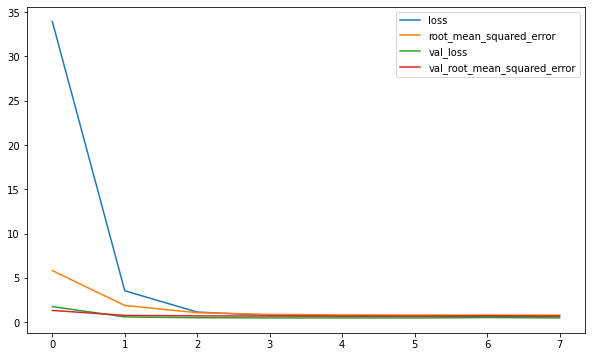

In [33]:
losses_df1.plot(figsize = (10,6))

In [55]:
scores = model1.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model1.metrics_names[0], scores[0]*100))
print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))

loss: 55.69%
root_mean_squared_error: 74.62%


#### Save the Keras model if it's the final version

In [52]:
save_model(model1, "LSTM_Models/lstm_univariate.h5")

#### Load the Keras model afterwards, so that we don't have to train the model each time we restart our jupyter notebook

In [37]:
model1 = load_model('LSTM/lstm_univariate.h5')

#### Predict on Test data

In [46]:
test_predictions1 = model1.predict(X_test).flatten()
test_predictions1

array([12.233923 , 11.485084 , 11.884583 , ..., -1.7929276, -2.9912076,
       -2.9950013], dtype=float32)

In [47]:
len(X_test), len(test_predictions1)

(5081, 5081)

In [48]:
# check the dimension of the output (should be 1 for time series forecast)

test_predictions1.ndim

1

In [49]:
X_test_list = []
for i in range(len(X_test)):
    X_test_list.append(X_test[i][0])
    
len(X_test_list)

5081

In [50]:
test_predictions_df1 = pd.DataFrame({'X_test':list(X_test_list), 'LSTM Prediction':list(test_predictions1)})
len(test_predictions_df1)

5081

In [56]:
test_predictions_df1.head()

,X_test,LSTM Prediction
0,18.27,12.233923
1,17.85,11.485084
2,16.65,11.884583
3,15.85,16.209522
4,15.09,20.267723


### LSTM temperature forecast on complete Test Data (211.7 days)

<AxesSubplot:>

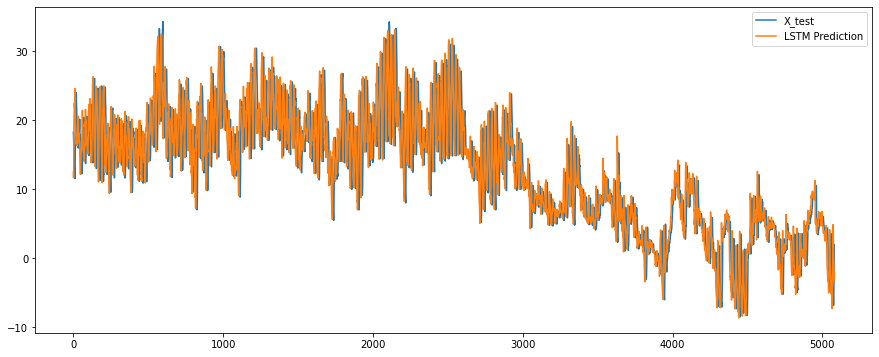

In [179]:
test_predictions_df1.plot(figsize = (15,6))

### LSTM temperature forecast on last 1 Month in the Test Data (720 hours)

<AxesSubplot:>

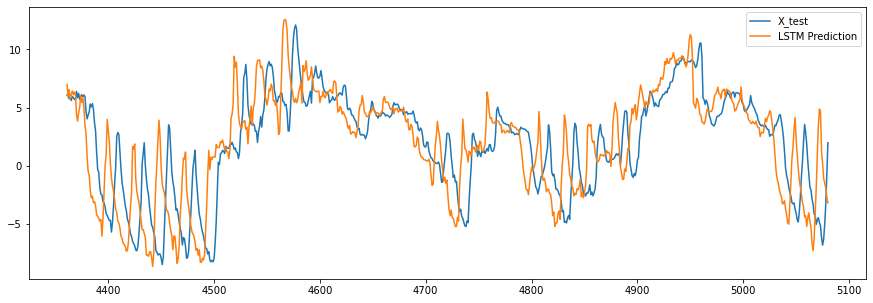

In [180]:
test_predictions_df1[(len(X_test) - 720):].plot(figsize = (15,5))

#### If the model is not providing good forecast, we need to try different things such as data scaling, data transformation, use more LSTM or Dense layers (requires more computing power) or hyperparameter tuning

## Now Making Future Forecast using LSTM model

In [58]:
def futureForecast(df, col, n_input, n_features, forecast_timeperiod, model):

    x_input = np.array(df[len(df)-n_input:][col])

    temp_input=list(x_input)

    lst_output=[]
    i=0

    while(i < forecast_timeperiod):

        if(len(temp_input) > n_input):

            x_input = np.array(temp_input[1:])
            x_input = x_input.reshape((1, n_input, n_features))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])
            temp_input = temp_input[1:]
            lst_output.append(yhat[0][0])

            i=i+1

        else:
            x_input = x_input.reshape((1, n_input, n_features))
            yhat = model.predict(x_input, verbose=0)
            #print(yhat[0])
            temp_input.append(yhat[0][0])
            lst_output.append(yhat[0][0])

            i=i+1
            
    return lst_output

In [59]:
df_hour_lvl.head()

,datetime,T
0,2009-01-01 01:00:00,-8.05
1,2009-01-01 02:00:00,-8.88
2,2009-01-01 03:00:00,-8.81
3,2009-01-01 04:00:00,-9.05
4,2009-01-01 05:00:00,-9.63


In [60]:
n_input = 10
n_features = 1
forecast_timeperiod = 240         # next 10 days
model = model1

forecast_output = futureForecast(df_hour_lvl, 'T', n_input, n_features, forecast_timeperiod, model)

In [61]:
len(forecast_output)

240

In [62]:
last_10_days = df_hour_lvl['T'][len(df_hour_lvl) - 240:].tolist()

next_10_days = pd.DataFrame(forecast_output, columns = ['FutureForecast'])

In [63]:
next_10_days.head()

,FutureForecast
0,-4.120708
1,-4.142042
2,-4.020559
3,-3.643923
4,-3.015779


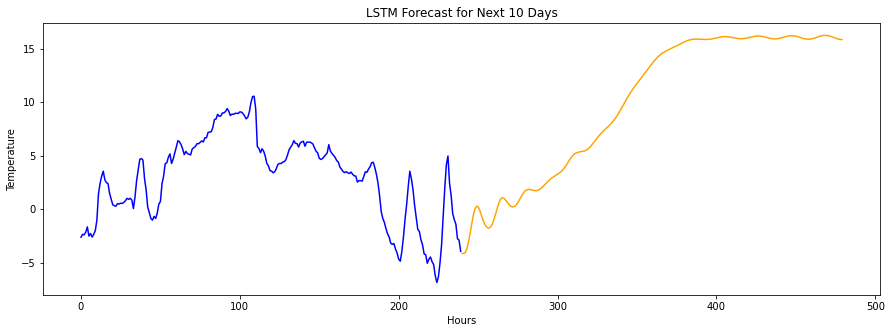

In [72]:
plt.figure(figsize = (15,5))

hist_axis = len(last_10_days)
forecast_axis = hist_axis + len(next_10_days)

plt.plot(np.arange(0,hist_axis),last_10_days, color = 'blue')
plt.plot(np.arange(hist_axis,forecast_axis),next_10_days['FutureForecast'].tolist(), color = 'orange')

plt.title('LSTM Forecast for Next 10 Days')
plt.xlabel('Hours')
plt.ylabel('Temperature')

# save the figure
plt.savefig('Pics_Models/lstm_univariate_forecast_pic.png')
plt.savefig('Pics_Models/lstm_univariate_forecast_pdf.pdf')

## Thank you

### Feel free to connect with me for further discussions on Time Series Analysis.

#### LinkedIn : https://www.linkedin.com/in/vineet-pandya/

#### Medium : https://medium.com/@vineet.pandya

#### Email : vineet.pandya@yahoo.com